Topic:predict kaggle_House_Prices

1.read table

In [32]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
%matplotlib inline



In [6]:
os.getcwd()
os.chdir('/Users/ting/Desktop/kaggle_House_Prices/')

In [7]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
all_data = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'], 
                      test.loc[:, 'MSSubClass':'SaleCondition']), ignore_index = True)
#all_data
#all_data.describe().T
all_data.to_csv("all_data.csv")
all_data.shape

(2919, 79)

2.處理NA

找出有NA的欄位

In [8]:
all_data_null = pd.DataFrame(all_data.isnull().sum())
all_data_null = all_data_null.T
all_data_null
#all_data_null.loc[:,'Id']
#all_data_null.drop('Id', 1)


for i in range(0,35):
    if all_data_null.loc[0,all_data_null.columns[i]] == 0:
        all_data_null = all_data_null.drop(all_data_null.columns[i], 1)
        for i in range(0,35):
            if all_data_null.loc[0,all_data_null.columns[i]] == 0:
                all_data_null = all_data_null.drop(all_data_null.columns[i], 1)
                

print(all_data_null)
print(all_data_null.shape)
all_data_null.isnull().sum()

   MSZoning  LotFrontage  Alley  Utilities  Exterior1st  Exterior2nd  \
0         4          486   2721          2            1            1   

   MasVnrType  MasVnrArea  BsmtQual  BsmtCond    ...     GarageYrBlt  \
0          24          23        81        82    ...             159   

   GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond  PoolQC  \
0           159           1           1         159         159    2909   

   Fence  MiscFeature  SaleType  
0   2348         2814         1  

[1 rows x 34 columns]
(1, 34)


MSZoning        0
LotFrontage     0
Alley           0
Utilities       0
Exterior1st     0
Exterior2nd     0
MasVnrType      0
MasVnrArea      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinSF1      0
BsmtFinType2    0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
Electrical      0
BsmtFullBath    0
BsmtHalfBath    0
KitchenQual     0
Functional      0
FireplaceQu     0
GarageType      0
GarageYrBlt     0
GarageFinish    0
GarageCars      0
GarageArea      0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
SaleType        0
dtype: int64

In [9]:
all_data_null.T

,0
MSZoning,4
LotFrontage,486
Alley,2721
Utilities,2
Exterior1st,1
Exterior2nd,1
MasVnrType,24
MasVnrArea,23
BsmtQual,81
BsmtCond,82


從空值多的開始處理

處理LotFrontage的NA-----利用LotFrontage與LotArea的關係

In [10]:
'''
plt.hist(all_data.LotArea)
plt.show()
#LotArea 大部分值 <= 25000

LotFrontage_notnull = all_data.LotFrontage.fillna(0)
plt.hist(LotFrontage_notnull)
plt.show()
#LotFrontage 大部分值 <= 150

'''

LotArea_LotFrontage_notnull = all_data.loc[np.logical_not(all_data.LotFrontage.isnull()), "LotArea"]
LotFrontage_notnull = all_data.loc[np.logical_not(all_data.LotFrontage.isnull()), "LotFrontage"]

'''
plt.scatter(LotArea_LotFrontage_notnull, LotFrontage_notnull)
plt.show()
'''

LotArea_LotFrontage_notnull_1 = LotArea_LotFrontage_notnull[LotFrontage_notnull < 150]
LotFrontage_notnull_1 = LotFrontage_notnull[LotArea_LotFrontage_notnull < 25000]
p = np.polyfit(LotArea_LotFrontage_notnull_1[LotArea_LotFrontage_notnull_1 < 25000],
               LotFrontage_notnull_1[LotFrontage_notnull_1 < 150], 1)
np.poly1d(p)

all_data.loc[all_data.LotFrontage.isnull(), "LotFrontage"] = np.polyval(p, all_data.loc[all_data.LotFrontage.isnull(),
                                                                                        "LotArea"])

#all_data

處理雙方的NA-----利用MasVnrType與MasVnrArea的關係

In [11]:
#MasVnrType
all_data.loc[all_data.MasVnrType.isnull(), "MasVnrArea"]
#MasVnrArea = 2610特殊，MasVnrType = null時有值
all_data.loc[all_data.MasVnrArea == 198, 'MasVnrType']
#198中stone最多
all_data.loc[2610, "MasVnrType"] = 'Stone'
all_data.loc[all_data.MasVnrType.isnull(), "MasVnrType"] = 'None'

'''
#由下面可以知道 MasVnrType = None 時MasVnrArea 不一定為0
k1 = 0
for i in range(0,1700):
    k = all_data.loc[all_data.MasVnrType == 'None', "MasVnrArea"].reset_index()["MasVnrArea"][i]
    k1 = k1 + k
    print(k1)
'''

'''
#找出MasVnrType = None 時MasVnrArea 不為0的值 
for i in range(0,1741):
    k = all_data.loc[all_data.MasVnrType == 'None', "MasVnrArea"].reset_index()["MasVnrArea"][i]
    if k != 0:
        print(i,k)
        print(all_data.loc[all_data.MasVnrType == 'None', "MasVnrArea"].reset_index()["index"][i])
'''
#MasVnrType = None 時MasVnrArea = 288.0 Id = 624
all_data.loc[all_data.MasVnrArea == 288, "MasVnrType"]
#BrkFace最多
all_data.loc[624, "MasVnrType"] = 'BrkFace'

#MasVnrType = None 時MasVnrArea = 1.0 Id = 773,729,1445
all_data.loc[all_data.MasVnrArea == 1.0, "MasVnrType"]
#None最多
all_data.loc[773, "MasVnrType"] = 'None'
all_data.loc[1230, "MasVnrType"] = 'None'
all_data.loc[2452, "MasVnrType"] = 'None'

#MasVnrType = None 時MasVnrArea = 344.0 Id = 1300
all_data.loc[all_data.MasVnrArea == 344.0, "MasVnrType"]
all_data.loc[1300, "MasVnrType"] = 'BrkFace'

#MasVnrType = None 時MasVnrArea = 312.0 Id = 1334
all_data.loc[all_data.MasVnrArea == 312.0, "MasVnrType"]
all_data.loc[1334, "MasVnrType"] = 'BrkFace'

#MasVnrType = None 時MasVnrArea = 285.0 Id = 1669
all_data.loc[all_data.MasVnrArea == 285.0, "MasVnrType"]
all_data.loc[1669, "MasVnrType"] = 'BrkFace'





處理bsm那部分，將BsmtFinSF1、BsmtFinSF2的nan填成0

In [12]:
######BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,smtFullBath
#,BsmtHalfBath
all_data.loc[all_data.BsmtQual.isnull(), 'BsmtQual'] = 'NoBsmt'
all_data.loc[all_data.BsmtCond.isnull(), 'BsmtCond'] = 'NoBsmt'
all_data.loc[all_data.BsmtExposure.isnull(), 'BsmtExposure'] = 'NoBsmt'
all_data.loc[all_data.BsmtFinType1.isnull(), 'BsmtFinType1'] = 'NoBsmt'
all_data.loc[all_data.BsmtFinType2.isnull(), 'BsmtFinType2'] = 'NoBsmt'

'''
#BsmtFinType1=='NoBsmt' 時MasVnrArea = 0 V nan，且BsmtFinType1!='NoBsmt' 時MasVnrArea != 0 V nan
k1 = 0
for i in range(0,79):
    k = all_data.loc[all_data.BsmtFinType1=='NoBsmt', 'BsmtFinSF1'].reset_index()["BsmtFinSF1"][i]
    k1 = k1 + k
    print(k1)
#BsmtFinType2同理
'''
all_data.loc[all_data.BsmtFinType1=='NoBsmt', 'BsmtFinSF1'] = 0
#all_data.loc[all_data.loc[:, 'BsmtFinSF1'].isnull(), 'BsmtFinSF1']
all_data.loc[all_data.BsmtFinType2=='NoBsmt', 'BsmtFinSF2'] = 0
#all_data.loc[all_data.loc[:, 'BsmtFinSF2'].isnull(), 'BsmtFinSF2']

'''
#BsmtQual=='NoBsmt' 時BsmtUnfSF 不為0的值 
for i in range(0,81):
    k = all_data.loc[all_data.BsmtQual=='NoBsmt', 'BsmtUnfSF'].reset_index()['BsmtUnfSF'][i]
    if k != 0:
        print(i,k)
        print(all_data.loc[all_data.BsmtQual=='NoBsmt', 'BsmtUnfSF'].reset_index()["index"][i])
'''
all_data.loc[2120, 'BsmtUnfSF'] = 0

all_data.loc[all_data.BsmtUnfSF == 173, 'BsmtQual']
all_data.loc[2217, 'BsmtUnfSF'] = 'Gd'

all_data.loc[all_data.BsmtUnfSF == 356, 'BsmtQual']
all_data.loc[2218, 'BsmtUnfSF'] = 'Gd'

all_data.loc[all_data.BsmtQual=='NoBsmt', 'BsmtUnfSF'] = 0
#all_data.loc[all_data.BsmtUnfSF.isnull(), 'BsmtUnfSF']
#BsmtUnfSF沒有空值了

'''
#BsmtQual=='NoBsmt' 時TotalBsmtSF 不為0的值 
for i in range(0,81):
    k = all_data.loc[all_data.BsmtQual=='NoBsmt', 'TotalBsmtSF'].reset_index()['TotalBsmtSF'][i]
    if k != 0:
        print(i,k)
        print(all_data.loc[all_data.BsmtQual=='NoBsmt', 'TotalBsmtSF'].reset_index()["index"][i])
'''
all_data.loc[2120, 'TotalBsmtSF'] = 0
all_data.loc[2217, 'TotalBsmtSF'] = 'Gd'
all_data.loc[2218, 'TotalBsmtSF'] = 'Gd'
all_data.loc[all_data.BsmtQual=='NoBsmt', 'TotalBsmtSF'] = 0
#all_data.loc[all_data.BsmtUnfSF.isnull(), 'TotalBsmtSF']
#TotalBsmtSF沒有空值了

all_data.loc[all_data.BsmtFullBath.isnull(), 'BsmtFullBath'] = 0
all_data.loc[all_data.BsmtHalfBath.isnull(), 'BsmtHalfBath'] = 0

處理gara那部分

In [13]:
all_data.loc[all_data.GarageType.isnull(), 'GarageType'] = 'NoGarage'
all_data.loc[all_data.GarageFinish.isnull(), 'GarageFinish'] = 'NoGarage'
all_data.loc[all_data.GarageQual.isnull(), 'GarageQual'] = 'NoGarage'
all_data.loc[all_data.GarageCond.isnull(), 'GarageCond'] = 'NoGarage'
all_data.loc[all_data['GarageArea'].isnull(), 'GarageArea'] = all_data.loc[all_data['GarageType']=='Detchd', 'GarageArea'].mean()
all_data.loc[all_data['GarageCars'].isnull(), 'GarageCars'] = all_data.loc[all_data['GarageType']=='Detchd', 'GarageCars'].median()
#利用分群處理GarageYrBlt
yrblt_group = pd.concat(pd.Series('yeargroup' + str(1 + i), index = range(1871 + i*20, 1891 + i*20)) for i in range(0,7))
all_data.yeargroup = all_data.GarageYrBlt.map(yrblt_group)
all_data.loc[all_data['GarageYrBlt'].isnull(), 'GarageYrBlt'] = 'NoGarage'

將最多的值塞入空值或根據文件重新定義空值

In [14]:
##### MSZoning 最多值 = 'RL'
#all_data.loc[all_data.MSZoning == 'RL' , "MSZoning"]
all_data.loc[all_data.MSZoning.isnull() , "MSZoning"] = 'RL'

###### Alley
all_data.loc[all_data.Alley.isnull(), "Alley"] = 'NoAlley'

##### Utilities 最多值 = 'AllPub'
#all_data.loc[all_data.Utilities == 'AllPub', 'Utilities']
all_data.loc[all_data.Utilities.isnull() , "Utilities"] = 'AllPub'

##### 尋找Exterior1st 最多值 
'''
for i in ('AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 
          'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing'):
    k = all_data.loc[all_data.Exterior1st == i, 'Exterior1st'].shape
    print(i, k)
#最多值為VinylSd
'''    
all_data.loc[all_data.Exterior1st.isnull(), 'Exterior1st'] = 'VinylSd'

##### Exterior2nd最多值 = 'VinylSd'
all_data.loc[all_data.Exterior2nd.isnull(), 'Exterior2nd'] = 'VinylSd'

##### Electrical最多值 = 'SBrkr'
#all_data.loc[all_data['Electrical'] == 'SBrkr', 'Electrical']
all_data.loc[all_data.Electrical.isnull(), 'Electrical'] = 'SBrkr'

#####'KitchenQual'
all_data.loc[all_data.KitchenQual.isnull(), 'KitchenQual'] = 'TA'

#####'Functional'
all_data.loc[all_data.Functional.isnull(), 'Functional'] = 'Typ'

##### 'FireplaceQu'
all_data.loc[all_data.FireplaceQu.isnull(), 'FireplaceQu'] = 'NoFireplace'

##### 'PoolQC'
all_data.loc[all_data['PoolQC'].isnull(), 'PoolQC'] = 'NoPool'

##### 'Fence'
all_data.loc[all_data['Fence'].isnull(), 'Fence'] = 'NoFence'

##### 'MiscFeature'
all_data.loc[all_data['MiscFeature'].isnull(), 'MiscFeature'] = 'None'

##### SaleType

all_data.loc[all_data.SaleType.isnull(), 'SaleType']
all_data.loc[2489, 'SaleCondition']
all_data.loc[all_data.SaleCondition == 'Normal', 'SaleType']

#查詢是否有不是WD的
k1 = []
for i in range(1,2402):
    k = all_data.loc[all_data.SaleCondition == 'Normal', 'SaleType'].reset_index()["SaleType"][i]
    if k != 'WD':
        k1.append(k)
print(k1)

len(k1)

#有不是WD的，計算不是的各種類數量
#無法排序有浮點數，找出令成str
for i in range(1,87):
    if type(k1[i]) == float:
        print(i)

k1[75] = 'NAN'

#排序，找出各種類數目
k1.sort
k1

k_1 = []
k_2 = []
for i in range(1,87):
    if k1[i] == 'COD':
        k_1.append(i)
    elif k1[i] == 'ConLD':
        k_2.append(i)
        
len(k_1)  #39
len(k_2)  #21
#都不多，所以最多的是WD

all_data.loc[all_data.SaleCondition.isnull(), 'SaleType'] = 'WD'



['COD', 'COD', 'ConLI', 'COD', 'COD', 'COD', 'ConLI', 'CWD', 'ConLw', 'Con', 'ConLw', 'ConLD', 'ConLw', 'ConLI', 'COD', 'ConLD', 'COD', 'COD', 'COD', 'ConLI', 'COD', 'ConLw', 'COD', 'Con', 'COD', 'COD', 'ConLD', 'COD', 'COD', 'COD', 'ConLD', 'COD', 'ConLD', 'COD', 'ConLD', 'CWD', 'ConLw', 'COD', 'COD', 'ConLD', 'ConLD', 'COD', 'ConLD', 'COD', 'COD', 'ConLD', 'ConLw', 'COD', 'ConLD', 'ConLD', 'COD', 'ConLI', 'COD', 'ConLD', 'Oth', 'COD', 'ConLD', 'COD', 'ConLD', 'ConLD', 'COD', 'Con', 'ConLD', 'COD', 'ConLD', 'CWD', 'COD', 'CWD', 'COD', 'CWD', 'CWD', 'COD', 'COD', 'ConLw', 'CWD', nan, 'COD', 'CWD', 'Con', 'COD', 'CWD', 'CWD', 'COD', 'COD', 'COD', 'ConLD', 'ConLD', 'ConLD']
75


3.轉換資料，從資料中攫取更多資訊

In [15]:
#尋找需要設置dummy variables的欄位
for i in range(1, 79):
    if type(all_data.loc[1, all_data.loc[0,:].index[i]]) == str:
        print(all_data.loc[0,:].index[i])
#all_data.dtypes[all_data.dtypes == "object"].index

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


In [16]:
#對某些欄位進行質-->量設置
all_data = all_data.replace( {'Street': {'Pave': 1, 'Grvl': 0 },
                             'Utilities': {'AllPub': 1, 'NoSeWa': 0, 'NoSewr': 0, 'ELO': 0}, 
                             'ExterQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1
                                             },
                             'ExterCond': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1
                                            }, 
                             'BsmtQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoBsmt': 0},
                             'BsmtCond': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoBsmt': 0},
                             'BsmtExposure': {'Gd': 3, 
                                            'Av': 2, 
                                            'Mn': 1,
                                            'No': 0,
                                            'NoBsmt': 0},
                             'CentralAir': {'Y': 1, 
                                            'N': 0}, 
                             'KitchenQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1},
                             'Functional': {'Typ': 0,
                                            'Min1': 1,
                                            'Min2': 1,
                                            'Mod': 2,
                                            'Maj1': 3,
                                            'Maj2': 4,
                                            'Sev': 5,
                                            'Sal': 6},                             
                             'FireplaceQu': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoFireplace': 0 
                                            },
                             'GarageQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoGarage': 0},
                             'GarageCond': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoGarage': 0},
                              'PavedDrive': {'Y': 1, 
                                            'P': 0,
                                            'N': 0},
                              'Fence': {'GdPrv': 2, 
                                        'GdWo': 2, 
                                        'MnPrv': 1, 
                                        'MnWw': 1,
                                        'NoFence': 0}})

In [17]:
#設置新欄位
newer_dwelling = all_data.MSSubClass.replace({20: 1, 
                                            30: 0, 
                                            40: 0, 
                                            45: 0,
                                            50: 0, 
                                            60: 1,
                                            70: 0,
                                            75: 0,
                                            80: 0,
                                            85: 0,
                                            90: 0,
                                           120: 1,
                                           150: 0,
                                           160: 0,
                                           180: 0,
                                           190: 0})
newer_dwelling.name = 'newer_dwelling'

MasVnrType_Any = all_data.MasVnrType.replace({'BrkCmn': 1,
                                              'BrkFace': 1,
                                              'CBlock': 1,
                                              'Stone': 1,
                                              'None': 0})
MasVnrType_Any.name = 'MasVnrType_Any'

bad_heating = all_data.HeatingQC.replace({'Ex': 0, 
                                          'Gd': 0, 
                                          'TA': 0, 
                                          'Fa': 1,
                                          'Po': 1})
bad_heating.name = 'bad_heating'
                                          
season = all_data.MoSold.replace( {1: 0, 
                                   2: 0, 
                                   3: 0, 
                                   4: 1,
                                   5: 1, 
                                   6: 1,
                                   7: 1,
                                   8: 0,
                                   9: 0,
                                  10: 0,
                                  11: 0,
                                  12: 0})
season.name = 'season'

SaleCondition_PriceDown = all_data.SaleCondition.replace({'Abnorml': 1,
                                                          'Alloca': 1,
                                                          'AdjLand': 1,
                                                          'Family': 1,
                                                          'Normal': 0,
                                                          'Partial': 0})
SaleCondition_PriceDown.name = 'SaleCondition_PriceDown'


In [18]:
#銷售年份標準化
all_data.YrSold = 2010 - all_data.YrSold

In [19]:
#品質可能影響價格，抓出跟品質有關的欄位做處理，生成新欄位
overall_poor_qu = all_data.OverallQual.copy()
overall_poor_qu = 5 - overall_poor_qu
overall_poor_qu[overall_poor_qu<0] = 0
overall_poor_qu.name = 'overall_poor_qu'

overall_good_qu = all_data.OverallQual.copy()
overall_good_qu = overall_good_qu - 5
overall_good_qu[overall_good_qu<0] = 0
overall_good_qu.name = 'overall_good_qu'

overall_poor_cond = all_data.OverallCond.copy()
overall_poor_cond = 5 - overall_poor_cond
overall_poor_cond[overall_poor_cond<0] = 0
overall_poor_cond.name = 'overall_poor_cond'

overall_good_cond = all_data.OverallCond.copy()
overall_good_cond = overall_good_cond - 5
overall_good_cond[overall_good_cond<0] = 0
overall_good_cond.name = 'overall_good_cond'

exter_poor_qu = all_data.ExterQual.copy()
exter_poor_qu[exter_poor_qu<3] = 1
exter_poor_qu[exter_poor_qu>=3] = 0
exter_poor_qu.name = 'exter_poor_qu'

exter_good_qu = all_data.ExterQual.copy()
exter_good_qu[exter_good_qu<=3] = 0
exter_good_qu[exter_good_qu>3] = 1
exter_good_qu.name = 'exter_good_qu'

exter_poor_cond = all_data.ExterCond.copy()
exter_poor_cond[exter_poor_cond<3] = 1
exter_poor_cond[exter_poor_cond>=3] = 0
exter_poor_cond.name = 'exter_poor_cond'

exter_good_cond = all_data.ExterCond.copy()
exter_good_cond[exter_good_cond<=3] = 0
exter_good_cond[exter_good_cond>3] = 1
exter_good_cond.name = 'exter_good_cond'

bsmt_poor_cond = all_data.BsmtCond.copy()
bsmt_poor_cond[bsmt_poor_cond<3] = 1
bsmt_poor_cond[bsmt_poor_cond>=3] = 0
bsmt_poor_cond.name = 'bsmt_poor_cond'

bsmt_good_cond = all_data.BsmtCond.copy()
bsmt_good_cond[bsmt_good_cond<=3] = 0
bsmt_good_cond[bsmt_good_cond>3] = 1
bsmt_good_cond.name = 'bsmt_good_cond'

kitchen_poor_qu = all_data.KitchenQual.copy()
kitchen_poor_qu[kitchen_poor_qu<3] = 1
kitchen_poor_qu[kitchen_poor_qu>=3] = 0
kitchen_poor_qu.name = 'kitchen_poor_qu'

kitchen_good_qu = all_data.KitchenQual.copy()
kitchen_good_qu[kitchen_good_qu<=3] = 0
kitchen_good_qu[kitchen_good_qu>3] = 1
kitchen_good_qu.name = 'kitchen_good_qu'

garage_poor_qu = all_data.GarageQual.copy()
garage_poor_qu[garage_poor_qu<3] = 1
garage_poor_qu[garage_poor_qu>=3] = 0
garage_poor_qu.name = 'garage_poor_qu'

garage_good_qu = all_data.GarageQual.copy()
garage_good_qu[garage_good_qu<=3] = 0
garage_good_qu[garage_good_qu>3] = 1
garage_good_qu.name = 'garage_good_qu'

garage_poor_cond = all_data.GarageCond.copy()
garage_poor_cond[garage_poor_cond<3] = 1
garage_poor_cond[garage_poor_cond>=3] = 0
garage_poor_cond.name = 'garage_poor_cond'

garage_good_cond = all_data.GarageCond.copy()
garage_good_cond[garage_good_cond<=3] = 0
garage_good_cond[garage_good_cond>3] = 1
garage_good_cond.name = 'garage_good_cond'

qu_list = pd.concat((overall_poor_qu, overall_good_qu, overall_poor_cond, overall_good_cond, exter_poor_qu,
                     exter_good_qu, exter_poor_cond, exter_good_cond, bsmt_poor_cond, bsmt_good_cond, garage_poor_qu,
                     garage_good_qu, garage_poor_cond, garage_good_cond, kitchen_poor_qu, kitchen_good_qu), axis=1)


In [20]:
#鄰居品質可能會影響價格，抽出來生成新欄位
Neighborhood_Good = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['Neighborhood_Good'])
Neighborhood_Good[all_data.Neighborhood=='NridgHt'] = 1
Neighborhood_Good[all_data.Neighborhood=='Crawfor'] = 1
Neighborhood_Good[all_data.Neighborhood=='StoneBr'] = 1
Neighborhood_Good[all_data.Neighborhood=='Somerst'] = 1
Neighborhood_Good[all_data.Neighborhood=='NoRidge'] = 1

In [21]:
#賣出日期不一定都比重構日期早(3)、可能相等(238)或晚，建造日期可能比賣出日期早(117)
#all_data.loc[all_data.YrSold-all_data.YearRemodAdd < 0,:]
#3
#all_data.loc[all_data.YrSold-all_data.YearBuilt < 0,:]
#1

recon_bef_buy = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns = ['reconbefbuy'])
recon_bef_buy[all_data.YearRemodAdd > all_data.YrSold] = 1
recon_bef_buy = recon_bef_buy.to_sparse()

recon_aft_buy = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns = ['reconaftbuy'])
recon_aft_buy[all_data.YearRemodAdd >= all_data.YrSold] = 1
recon_aft_buy = recon_aft_buy.to_sparse()

buil_aft_buy = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns = ['builaftbuy'])
buil_aft_buy[all_data.YearBuilt >= all_data.YrSold] = 1
buil_aft_buy = buil_aft_buy.to_sparse()

all_data.YearBuilt = all_data.YearBuilt.map(yrblt_group)
all_data.YearRemodAdd = all_data.YearRemodAdd.map(yrblt_group)

In [22]:
#將欄位設置不同群
all_data = all_data.replace({'MSSubClass': {20: 'SubClass_20', 
                                            30: 'SubClass_30', 
                                            40: 'SubClass_40', 
                                            45: 'SubClass_45',
                                            50: 'SubClass_50', 
                                            60: 'SubClass_60',
                                            70: 'SubClass_70',
                                            75: 'SubClass_75',
                                            80: 'SubClass_80',
                                            85: 'SubClass_85',
                                            90: 'SubClass_90',
                                           120: 'SubClass_120',
                                           150: 'SubClass_150',
                                           160: 'SubClass_160',
                                           180: 'SubClass_180',
                                           190: 'SubClass_190'}})

all_data = all_data.replace({'MoSold': {1: 'Yan', 
                                        2: 'Feb', 
                                        3: 'Mar', 
                                        4: 'Apr',
                                        5: 'May', 
                                        6: 'Jun',
                                        7: 'Jul',
                                        8: 'Avg',
                                        9: 'Sep',
                                        10: 'Oct',
                                        11: 'Nov',
                                        12: 'Dec'}})

In [23]:
#幾個欄位不知道如何擷取資訊，所以對他們進行分群，並將結果設置成新欄位
svm = SVC(C = 100)
pc = pd.Series(np.zeros(train.shape[0]))
pc[:] = 'pc1'
pc[train.SalePrice >= 150000] = 'pc2'
pc[train.SalePrice >= 220000] = 'pc3'
unknow_deal_coef = ['Exterior1st', 'Exterior2nd', 'RoofMatl', 'Condition1', 'Condition2', 'BldgType']
udc_pc = train.loc[:, unknow_deal_coef]
udc_pc = pd.get_dummies(udc_pc, sparse = True)
svm.fit(udc_pc, pc)
udc_pc_pre = pd.get_dummies(all_data.loc[:, unknow_deal_coef], sparse = True)
pc_cls_pre = svm.predict(udc_pc_pre)
pc_udc_pre = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns = ['pc'])
pc_udc_pre.loc[pc_cls_pre == 'pc2'] = 1
pc_udc_pre.loc[pc_cls_pre == 'pc3'] = 2
pc_udc_pre = pc_udc_pre.to_sparse()
#pc_udc_pre

In [24]:
#規範數值欄位
neu_col = all_data.dtypes[all_data.dtypes!= 'object'].index
neu_col_95_res = all_data[neu_col].quantile(.95)
neu_col_95_0_res = neu_col_95_res[neu_col_95_res == 0].index
neu_col_95_n0_res = neu_col_95_res[neu_col_95_res != 0].index

all_data[neu_col_95_0_res] = all_data[neu_col_95_0_res]/all_data[neu_col_95_0_res].max()
all_data[neu_col_95_n0_res] = all_data[neu_col_95_n0_res]/all_data[neu_col_95_n0_res].quantile(.95)

In [25]:
#neu_col_95_res，對95分位數大的、0以及是數值但dtype是'o'(BsmtUnfSF,TotalBsmtSF)(只有這兩個)的進行取log(1+x)
#all_data.loc[:, all_data.dtypes == 'O'].to_csv('是數值但dtype是'o'.csv')
pre_log_coe = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
     '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
     'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

#all_data.loc[:, pre_log_coe] = np.log1p(all_data.loc[:, pre_log_coe])
#np.log1p()不吃int, float

4.合成大表，準備訓練模型

In [26]:
X = pd.get_dummies(all_data, sparse=True)
X = X.fillna(0)
X = pd.concat((X, newer_dwelling, bad_heating, season, MasVnrType_Any, qu_list, recon_bef_buy, recon_aft_buy, 
               buil_aft_buy, pc_udc_pre), axis=1)

In [27]:
#面積跟品質相乘可以產生有價值的欄位
from itertools import product, chain

def poly(x):
    area = ['LotArea', 'GrLivArea', 'GarageArea']
    qul = chain(qu_list.axes[1].get_values(), ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtCond', 'GarageQual', 'GarageCond',
               'KitchenQual', 'bad_heating', 'MasVnrType_Any', 'Reconstruct',
               'ReconstructAfterBuy', 'Build.eq.Buy'])
#u_list.axes[1].get_values() practice again   
    for a,q in product(area, qul):
        x = X.loc[:, [a, q]].prod(1)
        x.name = a + '_' + q
        yield x

x_p = pd.concat(poly(X), axis = 1)
x = pd.concat((X, x_p), axis = 1)


In [28]:
X_train = X[:train.shape[0]]
X_test = X[train.shape[0]:]

In [29]:
y = np.log1p(train.SalePrice)

In [30]:
#cross_val_score
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

def rmsle(y, y_pred):
     return np.sqrt((( (np.log1p(y_pred*price_scale)- np.log1p(y*price_scale)) )**2).mean())

# scorer = make_scorer(rmsle, False)
scorer = make_scorer(mean_squared_error, False)

def rmse_cv(model, X, y):
     return (cross_val_score(model, X, y, scoring=scorer)).mean()

/Users/ting/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [31]:
#alpha用多少是最好
alphas = [1e-4, 5e-4, 1e-3, 5e-3]
cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter=50000), X_train, y) for alpha in alphas]
#cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter=50000), X_train, y) for alpha in alphas] practice again

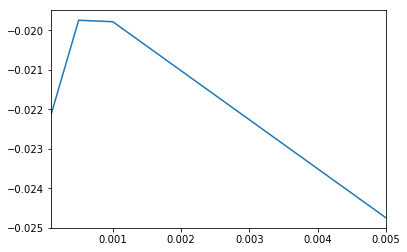

In [33]:
pd.Series(cv_lasso, index = alphas).plot()
#pd.Series(cv_lasso, index = alphas).plot() practice again

In [34]:
#得到最好alpha的模型
model_lasso = Lasso(alpha=5e-4, max_iter=50000).fit(X_train, y)

In [35]:
#預測結果
p = np.expm1(model_lasso.predict(X_test))
res = pd.DataFrame({"id":test.Id, "SalePrice":p}, columns=['id', 'SalePrice'])
res.to_csv("res.csv", index = False)